In [1]:
import json
import nltk
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions.normal as normal
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

from torch.nn.utils import clip_grad_norm_
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from nltk.tokenize import word_tokenize
from nltk.tokenize import MWETokenizer

from gensim.models import Word2Vec

nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\Mihaela
[nltk_data]     Stoycheva\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
torch.manual_seed(0)
np.random.seed(0)

### Functions

In [3]:
def load_data(filename, max_sentence_len):
    # the tokenizer splits <unk> so we use MWETokenizer to re-merge it
    data_original = []
    data_padded = []
    with open(filename) as f:
        for line in f:
            sentence, padded_sentence = tokenize_sentence(line, max_sentence_len)
            data_original.append(sentence)
            data_padded.append(padded_sentence)
    
    return data_original, data_padded

In [4]:
def tokenize_sentence(string, max_sentence_len):
    merger = MWETokenizer([('<', 'unk', '>')], separator = '') 
    sentence = word_tokenize(string.strip())       # tokenize sentence
    sentence = merger.tokenize(sentence)         # merge <unk>
    sentence = sentence[:max_sentence_len - 2]   # cut sentence at max_sentence_length
    sentence = ['<sos>'] + sentence + ['<eos>']  # add start and end-of-sentence tags

    # pad the rest of the sentence
    padded_sentence = sentence.copy()
    padded_sentence.extend(['<pad>']*(max_sentence_len - len(sentence))) 
    
    return sentence, padded_sentence

In [5]:
def get_batches_text(data, data_padded, batch_size, pad_index, word2vec_model):
    inputs = []
    targets = []
    lengths = []
    for i in range(len(data) // batch_size):
        # take batch_size sentences from the data each time
        batch_sentences = data[i*batch_size:(i+1)*batch_size]
        batch_sentence_lens = [len(x) for x in batch_sentences]
        
        # sentences in a batch have to be sorted in decreasing order of length (for pack_padded_sentence)
        sorted_pairs = sorted(zip(batch_sentence_lens,batch_sentences), reverse=True)
        batch_sentences = [sentence for length, sentence in sorted_pairs]
        batch_sentence_lens = [length-1 for length, sentence in sorted_pairs]
        
        # each input and target is a (batch_size x max_sentence_len-1 x 1) matrix
        # initially filled with the index for padditng tag <pad>
        input_batch = np.ones((batch_size, len(data_padded[0])-1, 1)) * pad_index
        target_batch = np.ones((batch_size, len(data_padded[0])-1, 1)) * pad_index
        
        # for each sentence in the batch, fill the corresponding row in current_batch
        # with the indexed of the words in the sentence (except for <pad>)
        for j, sentence in enumerate(batch_sentences):
            word_indexes = np.array([word2vec_model.wv.vocab[word].index for word in sentence])
            input_batch[j,0:len(sentence)-1,0] = word_indexes[:-1]
            target_batch[j,0:len(sentence)-1,0] = word_indexes[1:]
        
        # make the matrices into torch tensors and append
        inputs.append(input_batch)
        targets.append(target_batch)
        lengths.append(batch_sentence_lens)
    return inputs, targets, lengths

def get_batches_synthetic(data, batch_size):
    inputs = []
    targets = []

    for i in range(len(data) // batch_size):
        batch_sentences = data[i * batch_size:(i+1) * batch_size]

        input_batch = np.ones((batch_size, data.shape[1] - 1, 1)) 
        target_batch = np.ones((batch_size, data.shape[1] - 1, 1)) 
        for j, sentence in enumerate(batch_sentences):
                input_batch[j,0:len(sentence)-1,0] = sentence[:-1]
                target_batch[j,0:len(sentence)-1,0] = sentence[1:]
        inputs.append(input_batch)
        targets.append(target_batch)
    
    return inputs, targets

### Load Penn Treebank data

In [6]:
# max_sentence_length = 50
# train_data, train_data_padded = load_data("data/ptb.train.txt", max_sentence_length)
# val_data, val_data_padded = load_data("data/ptb.valid.txt", max_sentence_length)
# test_data, test_data_padded = load_data("data/ptb.test.txt", max_sentence_length)

### Load Synthetic data

In [7]:
test_syn_data = np.loadtxt('./synthetic-data/synthetic_test.txt', dtype=int)
train_syn_data = np.loadtxt('./synthetic-data/synthetic_train.txt', dtype=int)

In [8]:
batch_size = 16

# load tracked inputs (for plotting)
random_indices = np.random.choice(train_syn_data.shape[0], 500)
tracked_inputs = []
tracked_targets = []
for random_index in random_indices:
    tracked_inputs.append(train_syn_data[random_index, :-1])
    tracked_targets.append(train_syn_data[random_index, 1:])
tracked_inputs = np.expand_dims(np.array(tracked_inputs), axis=-1)
tracked_targets = np.expand_dims(np.array(tracked_targets), axis=-1)

# load data into batches
inputs, targets = get_batches_synthetic(train_syn_data, batch_size)

### Encoder-decoder

In [9]:
class Encoder(nn.Module):
    def __init__(self, hidden_size, num_layers, embedding_weights, synthetic=False):
        super(Encoder, self).__init__()
        # parameters
        self.embedding_size = embedding_weights.shape[1]
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_first = True
        
        #layers
        self.embed = nn.Embedding.from_pretrained(embedding_weights)
        self.lstm = nn.LSTM(self.embedding_size, self.hidden_size, self.num_layers, batch_first=self.batch_first)
        
    def forward(self, x, hidden, x_lens=None, train=True):
        batch_size, max_len, _ = x.shape
        
        x = torch.tensor(x, dtype=torch.long)  # make the input into a torch tensor
        x = self.embed(x).view(batch_size, max_len, self.embedding_size)

        if x_lens is not None and train:
            x_lens = torch.tensor(x_lens, dtype=torch.long)
            x = pack_padded_sequence(x, x_lens, batch_first=self.batch_first)
            
        output, hidden = self.lstm(x.float(), hidden) 

        if x_lens is not None and train:
            output, output_lens = pad_packed_sequence(output, batch_first=self.batch_first, 
                                                      total_length=max_sentence_length-1)
        return output, hidden
    
    def init_hidden(self, batch_size):
        h = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        c = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return (h, c)

In [10]:
class Decoder(nn.Module):
    def __init__(self,hidden_size, num_layers, embedding_weights, synthetic=False):
        super(Decoder, self).__init__()
        # parameters
        self.vocabulary_size = embedding_weights.shape[0]
        self.embedding_size = embedding_weights.shape[1]
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_first = True
        
        # layers
        self.embed = nn.Embedding.from_pretrained(embedding_weights)
        self.lstm = nn.LSTM(self.embedding_size, self.hidden_size, self.num_layers, batch_first=self.batch_first)
        self.linear = nn.Linear(self.hidden_size, self.vocabulary_size)

    def forward(self, x, hidden, x_lens=None, train=True):
        batch_size, max_len, _ = x.shape
        
        x = torch.tensor(x, dtype=torch.long)  # make the input into a torch tensor
        x = self.embed(x).view(batch_size, max_len, self.embedding_size)
        
        if x_lens is not None and train:
            x_lens = torch.tensor(x_lens, dtype=torch.long)
            x = pack_padded_sequence(x, x_lens, batch_first=self.batch_first)

        output, hidden = self.lstm(x.float(), hidden) 
        
        if x_lens is not None and train:
            output, output_lens = pad_packed_sequence(output, batch_first=self.batch_first, 
                                                      total_length=max_sentence_length-1)
        
        output = output.reshape(output.size(0)*output.size(1), output.size(2))
        output = self.linear(output)
        
        return output, hidden

### VAE

In [11]:
# class Stochastic(nn.Module):
#     def __init__(self, hidden_dim, num_layers, latent_dim, synthetic=False):
#         super(Stochastic, self).__init__()
#         self.latent_dim = latent_dim
#         self.hidden_dim = hidden_dim
#         self.batch_first = True
        
#         self.hidden_to_mean = nn.Linear(2 * self.hidden_dim * num_layers, self.latent_dim, self.batch_first)
#         self.hidden_to_logvar = nn.Linear(2 * self.hidden_dim * num_layers, self.latent_dim, self.batch_first)
#         self.latent_to_hidden = nn.Linear(latent_dim, 2 * self.hidden_dim * num_layers, self.batch_first)
        
# #         if synthetic:          
# #             for param in self.parameters():
# #                 nn.init.uniform_(param, -0.01, 0.01)

#     def reparametrize(self, mean, log_variance):
#         eps = torch.randn_like(mean)
#         return mean + eps * torch.exp(0.5 * log_variance)
        
#     def forward(self, hidden_concatenated):
#         mean = self.hidden_to_mean(hidden_concatenated)
#         log_variance = self.hidden_to_logvar(hidden_concatenated)
#         z = self.reparametrize(mean, log_variance)
#         hidden_concatenated = self.latent_to_hidden(z)
#         return hidden_concatenated, mean, log_variance

In [12]:
class StochasticEncoder(nn.Module):
    def __init__(self, hidden_dim, num_layers, latent_dim, synthetic=False):
        super(StochasticEncoder, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.batch_first = True
        
        self.hidden_to_mean = nn.Linear(2 * self.hidden_dim * num_layers, self.latent_dim, self.batch_first)
        self.hidden_to_logvar = nn.Linear(2 * self.hidden_dim * num_layers, self.latent_dim, self.batch_first)

    def reparametrize(self, mean, log_variance):
        eps = torch.randn_like(mean)
        return mean + eps * torch.exp(0.5 * log_variance)
        
    def forward(self, hidden_concatenated):
        mean = self.hidden_to_mean(hidden_concatenated)
        log_variance = self.hidden_to_logvar(hidden_concatenated)
        z = self.reparametrize(mean, log_variance)
        return z, mean, log_variance

In [13]:
class StochasticDecoder(nn.Module):
    def __init__(self, hidden_dim, num_layers, latent_dim, synthetic=False):
        super(StochasticDecoder, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.batch_first = True
        
        self.latent_to_hidden = nn.Linear(latent_dim, 2 * self.hidden_dim * num_layers, self.batch_first)
        
    def forward(self, z):
        hidden_concatenated = self.latent_to_hidden(z)
        return hidden_concatenated

In [14]:
# # new VAE
# class VAE(nn.Module):
#     def __init__(self, hidden_dim, num_layers, embedding_weights, latent_dim, synthetic=False):
#         super(VAE, self).__init__()
#         self.latent_dim = latent_dim
#         self.hidden_dim = hidden_dim
#         self.batch_first = True
        
#         self.encoder = Encoder(self.hidden_dim, num_layers, embedding_weights, synthetic)
#         self.stochastic = Stochastic(self.hidden_dim, num_layers, self.latent_dim, synthetic)
#         self.decoder = Decoder(self.hidden_dim, num_layers, embedding_weights, synthetic)
        
#         # THIS PART IS IMPORTANT -- I think it re-initialises all of the weights in the network with
#         ## this distribution, even the embedding weights, which we initialised to (-0.1,0.1) before;
#         ## with this distribution it (kind of) works both without annealing and with annealing 
#         ## (why??? who knows)
#         if synthetic:          
#             for param in self.parameters():
#                 nn.init.uniform_(param, -0.01, 0.01)
        
#     def encode(self, x, x_lens=None):
#         batch_size, max_len, _ = x.shape
#         hidden = self.encoder.init_hidden(batch_size)
#         _, hidden = self.encoder.forward(x, hidden, x_lens)
#         return hidden
    
#     def latent_to_hidden(self, x):
#         return self.stochastic.latent_to_hidden(x)
        
#     def decode(self, hidden, x, x_lens=None, train=True):
#         outputs, _ = self.decoder.forward(x, hidden, x_lens, train)
#         return outputs
    
#     def forward(self, x, x_lens=None):
#         hidden = self.encode(x, x_lens)
#         hidden_concatenated = torch.cat((hidden[0], hidden[1]), 2)
#         hidden_concatenated, mean, log_variance = self.stochastic(hidden_concatenated)
#         hidden = torch.split(hidden_concatenated, self.hidden_dim, dim=2)
#         outputs = self.decode(hidden, x, x_lens)
#         return mean, log_variance, outputs

In [24]:
# new VAE
class VAE(nn.Module):
    def __init__(self, hidden_dim, num_layers, embedding_weights, latent_dim, synthetic=False):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.batch_first = True
        
        self.encoder = Encoder(self.hidden_dim, num_layers, embedding_weights, synthetic)
        self.stochastic_encoder = StochasticEncoder(self.hidden_dim, num_layers, self.latent_dim, synthetic)
        self.stochastic_decoder = StochasticDecoder(self.hidden_dim, num_layers, self.latent_dim, synthetic)
        self.decoder = Decoder(self.hidden_dim, num_layers, embedding_weights, synthetic)
        
        # THIS PART IS IMPORTANT -- I think it re-initialises all of the weights in the network with
        ## this distribution, even the embedding weights, which we initialised to (-0.1,0.1) before;
        ## with this distribution it (kind of) works both without annealing and with annealing 
        ## (why??? who knows)
        if synthetic:          
            for param in self.parameters():
                nn.init.uniform_(param, -0.01, 0.01)
#             nn.init.uniform_(self.encoder.embed.weight, -0.01, 0.01)
#             nn.init.uniform_(self.decoder.embed.weight, -0.01, 0.01)
        
    def encode(self, x, x_lens=None):
        batch_size, max_len, _ = x.shape
        hidden = self.encoder.init_hidden(batch_size)
        _, hidden = self.encoder.forward(x, hidden, x_lens)
        return hidden
    
    def latent_to_hidden(self, z):
        return self.stochastic_decoder.latent_to_hidden(z)
        
    def decode(self, hidden, x, x_lens=None, train=True):
        outputs, _ = self.decoder.forward(x, hidden, x_lens, train)
        return outputs
    
    def forward(self, x, x_lens=None):
        hidden = self.encode(x, x_lens)
        hidden_concatenated = torch.cat((hidden[0], hidden[1]), 2)
        z, mean, log_variance = self.stochastic_encoder.forward(hidden_concatenated)
        hidden_concatenated = self.stochastic_decoder.forward(z)
        hidden = torch.split(hidden_concatenated, self.hidden_dim, dim=2)
        outputs = self.decode(hidden, x, x_lens)
        return mean, log_variance, outputs

In [25]:
# # old VAE
# class VAE(nn.Module):
#     def __init__(self, hidden_dim, num_layers, embedding_weights, latent_dim, synthetic=False):
#         super(VAE, self).__init__()
#         self.encoder = Encoder(hidden_dim, num_layers, embedding_weights, synthetic)
#         self.decoder = Decoder(hidden_dim, num_layers, embedding_weights, synthetic)
#         self.latent_dim = latent_dim
#         self.hidden_dim = hidden_dim
#         self.batch_first = True
        
#         self.hidden_to_mean = nn.Linear(2 * self.hidden_dim * num_layers, self.latent_dim, self.batch_first)
#         self.hidden_to_logvar = nn.Linear(2 * self.hidden_dim * num_layers, self.latent_dim, self.batch_first)
#         self.latent_to_hidden = nn.Linear(latent_dim, 2 * self.hidden_dim * num_layers, self.batch_first)
#         if synthetic:          
#             for param in self.parameters():
#                 nn.init.uniform_(param, -0.01, 0.01)
        
#     def reparametrize(self, mean, log_variance):
#         eps = torch.randn_like(mean)
#         return mean + eps * torch.exp(0.5 * log_variance)
        
#     def encode(self, x, x_lens=None):
#         batch_size, max_len, _ = x.shape
#         hidden = self.encoder.init_hidden(batch_size)
#         _, hidden = self.encoder.forward(x, hidden, x_lens)
#         return hidden
        
#     def decode(self, hidden, x, x_lens=None, train=True):
#         outputs, _ = self.decoder.forward(x, hidden, x_lens, train)
#         return outputs

#     def forward(self, x, x_lens=None):
#         hidden = self.encode(x, x_lens)
#         hidden_concatenated = torch.cat((hidden[0], hidden[1]), 2)
        
#         mean = self.hidden_to_mean(hidden_concatenated)
        
#         log_variance = self.hidden_to_logvar(hidden_concatenated)
#         z = self.reparametrize(mean, log_variance)
#         hidden = self.latent_to_hidden(z)
        
#         hidden = torch.split(hidden, self.hidden_dim, dim=2)
#         outputs = self.decode(hidden, x, x_lens)
#         return mean, log_variance, outputs

In [26]:
def loss_function(outputs, labels, mean, log_variance, annealing_args=None):
    BCE = nn.CrossEntropyLoss(reduction='sum')(outputs, labels)
    KLD = -0.5 * torch.sum(1 + log_variance - mean.pow(2) - log_variance.exp()) 
    if annealing_args is not None:
        kl_weight = kl_annealing_weight(annealing_args['type'], annealing_args['step'], annealing_args['k'], annealing_args['first_step'])
    else:
        kl_weight = 1.0
    BCE = BCE / mean.shape[1]  # divide by batch size
    KLD /= mean.shape[1]
    weighted_KLD = kl_weight * KLD
    loss = BCE + weighted_KLD
    return loss, BCE, KLD, weighted_KLD, kl_weight
    
def kl_annealing_weight(annealing_type, step, k, first_step):
    if annealing_type == 'logistic':
        return float(1/(1+np.exp(-k*(step-first_step))))
    elif annealing_type == 'linear':
        return min(1, step/first_step)

### True posterior

In [27]:
def log_sum_exp(value, dim=None, keepdim=False):
    """Numerically stable implementation of the operation
    value.exp().sum(dim, keepdim).log() - copied from repo, we should change it
    """
    if dim is not None:
        m, _ = torch.max(value, dim=dim, keepdim=True)
        value0 = value - m
        if keepdim is False:
            m = m.squeeze(dim)
        return m + torch.log(torch.sum(torch.exp(value0), dim=dim, keepdim=keepdim))
    else:
        m = torch.max(value)
        sum_exp = torch.sum(torch.exp(value - m))
        return m + torch.log(sum_exp)

def compute_true_posterior(latent_grid, vae, inputs, targets):
    log_true_posterior = compute_true_log_posterior(latent_grid, vae, inputs, targets)
    true_posterior = log_true_posterior.exp()
    return true_posterior

def compute_true_log_posterior(latent_grid, vae, inputs, targets):
    latent_grid = latent_grid.unsqueeze(0).expand(inputs.shape[0], *latent_grid.size()).contiguous().permute(1, 0, 2)
    
    # Compute the true joint
    log_true_joint = compute_true_joint(latent_grid, vae, inputs, targets)
    
    # Normalize by marginalizing z
    log_true_posterior = log_true_joint - log_sum_exp(log_true_joint, dim=0, keepdim=True)
    return log_true_posterior

def compute_true_joint(latent_grid, vae, inputs, targets):
    n_sample, batch_size, latent_dim = latent_grid.size()
    seq_len = inputs.shape[1]
    # Compute prior p(z)
    normal = torch.distributions.normal.Normal(torch.zeros(latent_dim), torch.ones(latent_dim))
    log_true_prior = normal.log_prob(latent_grid).sum(dim=-1)
    
    # Compute conditional p(x | z)
    log_true_conditional = torch.zeros(latent_grid.size(0), latent_grid.size(1))
    tensor_target_batch = torch.tensor(targets.reshape(-1), dtype=torch.long)
    for i in range(latent_grid.size(0)):
        hidden_concatenated = vae.latent_to_hidden(latent_grid[i]).unsqueeze(0)
        hidden = torch.split(hidden_concatenated, vae.hidden_dim, dim=-1)
        outputs = vae.decode(hidden, inputs, train=False)
        log_true_conditional[i] = -nn.CrossEntropyLoss(reduction='none')(outputs, tensor_target_batch).view(batch_size, -1).sum(-1)
        
    # Compute joint p(x, z)
    log_true_joint = log_true_prior + log_true_conditional
    return log_true_joint

def compute_true_posterior_mean(true_posterior, latent_grid):
    return torch.mul(true_posterior.unsqueeze(2), latent_grid.unsqueeze(0)).sum(1)

def generate_grid(lower, upper, step, dim=2):
    line = torch.arange(lower, upper, step)
    total_points = line.size(0)
    if dim == 2:
        z1 = line.unsqueeze(1).repeat(1, total_points).view(-1)
        z2 = line.repeat(total_points)
        return torch.cat((z1.unsqueeze(-1), z2.unsqueeze(-1)), dim=-1)
    elif dim == 1:
        return line.unsqueeze(1)

In [28]:
def plot_mean_space(step, latent_size, vae, tracked_inputs, tracked_targets, lim=3, iteration=None):
    latent_grid = generate_grid(-5, 5, step, latent_size)
    true_posterior = compute_true_posterior(latent_grid, vae, tracked_inputs, tracked_targets)
    true_mean = compute_true_posterior_mean(true_posterior.t(), latent_grid)
    approximate_mean, _, _ = vae(tracked_inputs)
    plt.figure(figsize=(5,5))
    plt.scatter(true_mean.detach().numpy(), approximate_mean.detach().numpy(), marker='x')
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)
    plt.xlabel("true postrior mean")
    plt.ylabel("approximate posterior mean")
    if iteration is not None:
        plt.title("iteration {0}".format(iteration))
    plt.show()

def plot_kl(kl_terms, kl_weights):
    plot_step = 10
    x_axis = np.arange(len(kl_terms[::plot_step])) * plot_step
    fig, ax1 = plt.subplots(figsize=(8,4))
    ax1.plot(x_axis, kl_terms[::plot_step], label="KL term value")
    ax1.set_xlabel("iteration")
    ax1.set_ylabel("KL term")
    ax2 = ax1.twinx()
    ax2.plot(x_axis, kl_weights[::plot_step], color="orange", label="KL weight")
    ax2.set_ylabel("KL weight")
    ax2.set_ylim(0,1)
    plt.legend()
    plt.show()
    
def plot_losses(total_loss, ce_loss, kl_loss):
    plot_step = 10
    x_axis = np.arange(len(total_loss[::plot_step])) * plot_step
    total_loss = np.array(total_loss[::plot_step])
    kl_loss = np.array(kl_loss[::plot_step])
    fig, ax1 = plt.subplots(figsize=(8,4))
    plt.fill_between(x_axis, np.zeros(len(x_axis)), total_loss, label="total loss")
    plt.fill_between(x_axis, np.zeros(len(x_axis)), kl_loss, label="kl loss")
    plt.xlabel("loss")
    plt.ylabel("iteration")
    plt.legend()
    plt.show()

## Experiments

In [29]:
def train(vae, inputs, targets, epochs, vocab_size, hidden_size, latent_size, input_lens=None, synthetic=False, 
          num_layers=1, step=1.0, learning_rate=0.001, tracked_inputs=None, tracked_targets=None, annealing_args=None, 
          aggressive_args=None, plot=False, plot_lim=1.5, verbose=True):
    
    enc_optimizer = torch.optim.Adam(vae.encoder.parameters(), lr=learning_rate, betas=(0.9, 0.999))
    stoch_enc_optimizer = torch.optim.Adam(vae.stochastic_encoder.parameters(), lr=learning_rate, betas=(0.9, 0.999))
    stoch_dec_optimizer = torch.optim.Adam(vae.stochastic_decoder.parameters(), lr=learning_rate, betas=(0.9, 0.999))
    dec_optimizer = torch.optim.Adam(vae.decoder.parameters(), lr=learning_rate, betas=(0.9, 0.999))
#    vae_optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate, betas=(0.9, 0.999))
    
    if annealing_args is not None:
        kl_terms = []
        kl_weights = []

    iteration = 0
    total_losses = []
    ce_losses = []
    kl_losses = []
    
    if plot:
        plot_mean_space(step, latent_size, vae, tracked_inputs, tracked_targets, lim=plot_lim, iteration=iteration)
        
    for epoch in range(epochs):        
        for i in range(len(inputs)):
            x = inputs[i]
            y = torch.tensor(targets[i].reshape(-1), dtype=torch.long)
            x_lens = input_lens[i] if not synthetic else None
                
            mean, log_variance, outputs = vae(x, x_lens=x_lens)
            if not synthetic:
                mask = (y < padding_index)
                outputs = outputs[mask]
                y = y[mask]

            loss_summary = loss_function(outputs, y, mean, log_variance, annealing_args=annealing_args)
            total_losses.append(loss_summary[0].data.item())
            ce_losses.append(loss_summary[1].data.item())
            kl_losses.append(loss_summary[3].data.item())
            
            loss = loss_summary[0]
            
            if annealing_args is not None:
                kl_terms.append(loss_summary[2].data.item())
                kl_weights.append(loss_summary[4])
            
            enc_optimizer.zero_grad()
            stoch_enc_optimizer.zero_grad()
            stoch_dec_optimizer.zero_grad()
            dec_optimizer.zero_grad()
#             vae_optimizer.zero_grad()
            
            loss.backward()
            clip_grad_norm_(vae.parameters(), 5.0)
            dec_optimizer.step()
            stoch_dec_optimizer.step()
            stoch_enc_optimizer.step()
            enc_optimizer.step()
            #vae_optimizer.step()

            if (iteration % 100 == 0) and verbose:
                print('epoch {} iteration {} loss {:.3f} CE {:.3f} KL {:.3f} weighted KL: {:.3f} weight {:.3f}'.format(epoch+1, 
                            iteration, loss_summary[0].data.item(), loss_summary[1].data.item(),
                            loss_summary[2].data.item(), loss_summary[3], loss_summary[4]))

            iteration += 1
            
            if annealing_args is not None:
                annealing_args['step'] = iteration

        if (epoch % 1 == 0) and plot:
            plot_mean_space(step, latent_size, vae, tracked_inputs, tracked_targets, lim=plot_lim, iteration=iteration)
       
        print ('Epoch [{}/{}], Loss: {:.4f}, Perplexity: {:5.2f}\n'
               .format(epoch + 1, epochs, loss.item(), np.exp(loss.item())))
    
    if annealing_args is not None:
        plot_kl(kl_terms, kl_weights)
    plot_losses(total_losses, ce_losses, kl_losses)

### Synthetic data

In [30]:
# without annealing
vocab_size = 1000
hidden_size = 50
embedding_size = 50
latent_size = 1
num_layers = 1
step = 0.25
learning_rate = 0.01
epochs = 10

embedding_weights = nn.Embedding(vocab_size, embedding_size).weight

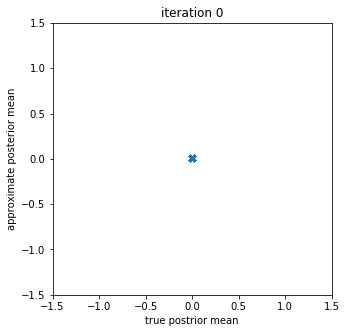

epoch 1 iteration 0 loss 62.174 CE 62.174 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 1 iteration 100 loss 45.946 CE 45.946 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 1 iteration 200 loss 45.406 CE 45.406 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 1 iteration 300 loss 42.812 CE 42.812 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 1 iteration 400 loss 45.649 CE 45.649 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 1 iteration 500 loss 42.685 CE 42.685 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 1 iteration 600 loss 48.022 CE 48.022 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 1 iteration 700 loss 42.793 CE 42.793 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 1 iteration 800 loss 41.969 CE 41.969 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 1 iteration 900 loss 38.370 CE 38.369 KL 0.001 weighted KL: 0.001 weight 1.000


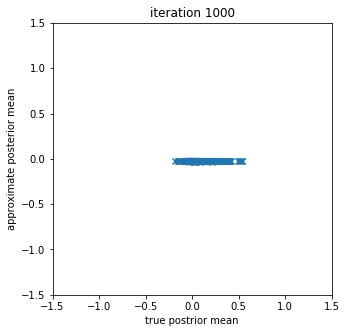

Epoch [1/10], Loss: 38.9705, Perplexity: 84077568723607408.00

epoch 2 iteration 1000 loss 45.412 CE 45.411 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 2 iteration 1100 loss 37.675 CE 37.675 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 2 iteration 1200 loss 36.600 CE 36.600 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 2 iteration 1300 loss 33.837 CE 33.837 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 2 iteration 1400 loss 37.875 CE 37.875 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 2 iteration 1500 loss 32.777 CE 32.777 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 2 iteration 1600 loss 42.405 CE 42.404 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 2 iteration 1700 loss 35.294 CE 35.294 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 2 iteration 1800 loss 36.791 CE 36.791 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 2 iteration 1900 loss 34.950 CE 34.950 KL 0.000 weighted KL: 0.000 weight 1.000


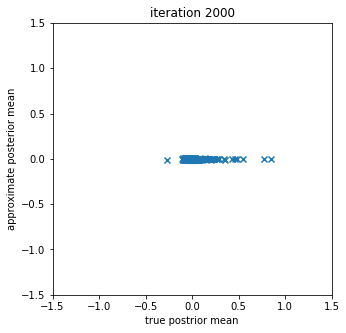

Epoch [2/10], Loss: 35.7730, Perplexity: 3435627291862866.00

epoch 3 iteration 2000 loss 41.899 CE 41.899 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 3 iteration 2100 loss 34.792 CE 34.792 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 3 iteration 2200 loss 34.955 CE 34.954 KL 0.001 weighted KL: 0.001 weight 1.000
epoch 3 iteration 2300 loss 31.973 CE 31.973 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 3 iteration 2400 loss 35.329 CE 35.328 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 3 iteration 2500 loss 30.666 CE 30.665 KL 0.001 weighted KL: 0.001 weight 1.000
epoch 3 iteration 2600 loss 41.080 CE 41.080 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 3 iteration 2700 loss 34.075 CE 34.075 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 3 iteration 2800 loss 35.354 CE 35.353 KL 0.001 weighted KL: 0.001 weight 1.000
epoch 3 iteration 2900 loss 33.449 CE 33.449 KL 0.000 weighted KL: 0.000 weight 1.000


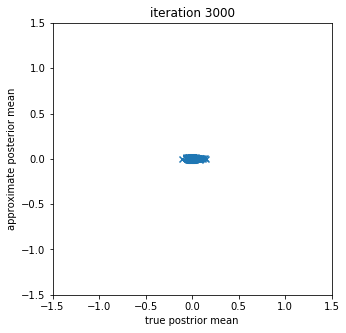

Epoch [3/10], Loss: 35.0541, Perplexity: 1674250501559011.50

epoch 4 iteration 3000 loss 41.782 CE 41.782 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 4 iteration 3100 loss 32.948 CE 32.948 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 4 iteration 3200 loss 33.535 CE 33.535 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 4 iteration 3300 loss 30.534 CE 30.534 KL 0.001 weighted KL: 0.001 weight 1.000
epoch 4 iteration 3400 loss 34.245 CE 34.245 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 4 iteration 3500 loss 29.246 CE 29.246 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 4 iteration 3600 loss 39.872 CE 39.871 KL 0.001 weighted KL: 0.001 weight 1.000
epoch 4 iteration 3700 loss 32.900 CE 32.899 KL 0.001 weighted KL: 0.001 weight 1.000
epoch 4 iteration 3800 loss 34.751 CE 34.751 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 4 iteration 3900 loss 32.835 CE 32.835 KL 0.000 weighted KL: 0.000 weight 1.000


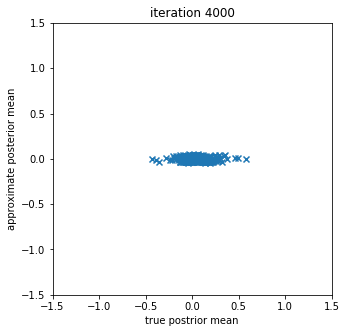

Epoch [4/10], Loss: 34.1137, Perplexity: 653687991044828.75

epoch 5 iteration 4000 loss 40.389 CE 40.389 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 5 iteration 4100 loss 31.558 CE 31.557 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 5 iteration 4200 loss 32.813 CE 32.813 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 5 iteration 4300 loss 29.828 CE 29.828 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 5 iteration 4400 loss 33.521 CE 33.521 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 5 iteration 4500 loss 28.832 CE 28.832 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 5 iteration 4600 loss 39.576 CE 39.576 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 5 iteration 4700 loss 32.094 CE 32.094 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 5 iteration 4800 loss 34.295 CE 34.294 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 5 iteration 4900 loss 32.378 CE 32.378 KL 0.000 weighted KL: 0.000 weight 1.000


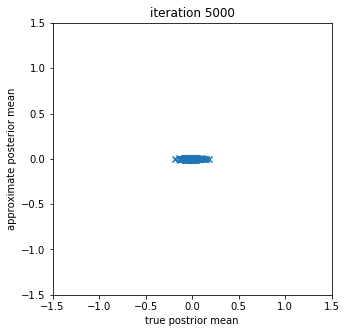

Epoch [5/10], Loss: 33.2814, Perplexity: 284396681054641.81

epoch 6 iteration 5000 loss 39.423 CE 39.423 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 6 iteration 5100 loss 30.857 CE 30.857 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 6 iteration 5200 loss 32.180 CE 32.180 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 6 iteration 5300 loss 29.218 CE 29.218 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 6 iteration 5400 loss 32.603 CE 32.603 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 6 iteration 5500 loss 28.619 CE 28.619 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 6 iteration 5600 loss 39.222 CE 39.222 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 6 iteration 5700 loss 31.437 CE 31.437 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 6 iteration 5800 loss 33.621 CE 33.621 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 6 iteration 5900 loss 31.922 CE 31.921 KL 0.000 weighted KL: 0.000 weight 1.000


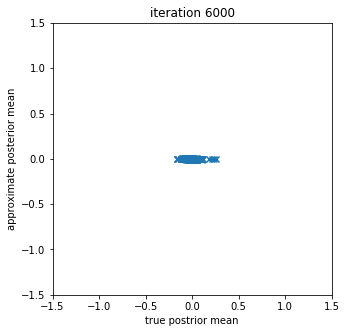

Epoch [6/10], Loss: 32.3281, Perplexity: 109626285963412.62

epoch 7 iteration 6000 loss 38.654 CE 38.654 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 7 iteration 6100 loss 30.257 CE 30.256 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 7 iteration 6200 loss 31.420 CE 31.420 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 7 iteration 6300 loss 28.862 CE 28.862 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 7 iteration 6400 loss 32.071 CE 32.071 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 7 iteration 6500 loss 28.412 CE 28.412 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 7 iteration 6600 loss 39.048 CE 39.048 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 7 iteration 6700 loss 31.266 CE 31.266 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 7 iteration 6800 loss 32.961 CE 32.961 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 7 iteration 6900 loss 31.664 CE 31.663 KL 0.000 weighted KL: 0.000 weight 1.000


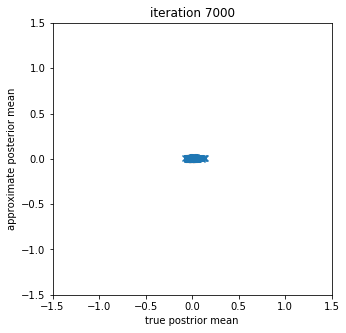

Epoch [7/10], Loss: 31.8944, Perplexity: 71051789775651.73

epoch 8 iteration 7000 loss 38.223 CE 38.223 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 8 iteration 7100 loss 29.784 CE 29.784 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 8 iteration 7200 loss 31.042 CE 31.042 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 8 iteration 7300 loss 28.580 CE 28.580 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 8 iteration 7400 loss 31.612 CE 31.612 KL 0.001 weighted KL: 0.001 weight 1.000
epoch 8 iteration 7500 loss 28.148 CE 28.148 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 8 iteration 7600 loss 38.976 CE 38.976 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 8 iteration 7700 loss 31.130 CE 31.129 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 8 iteration 7800 loss 32.467 CE 32.467 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 8 iteration 7900 loss 31.439 CE 31.439 KL 0.000 weighted KL: 0.000 weight 1.000


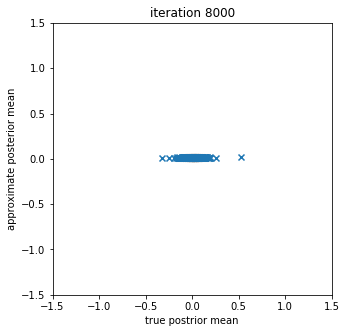

Epoch [8/10], Loss: 31.5366, Perplexity: 49676466667720.30

epoch 9 iteration 8000 loss 37.901 CE 37.901 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 9 iteration 8100 loss 29.341 CE 29.341 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 9 iteration 8200 loss 30.911 CE 30.911 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 9 iteration 8300 loss 28.404 CE 28.404 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 9 iteration 8400 loss 31.262 CE 31.262 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 9 iteration 8500 loss 27.911 CE 27.911 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 9 iteration 8600 loss 38.797 CE 38.797 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 9 iteration 8700 loss 31.133 CE 31.133 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 9 iteration 8800 loss 32.241 CE 32.241 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 9 iteration 8900 loss 31.161 CE 31.161 KL 0.000 weighted KL: 0.000 weight 1.000


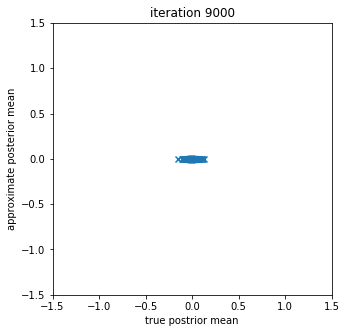

Epoch [9/10], Loss: 31.4282, Perplexity: 44573289216252.86

epoch 10 iteration 9000 loss 37.456 CE 37.456 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 10 iteration 9100 loss 29.044 CE 29.044 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 10 iteration 9200 loss 30.797 CE 30.797 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 10 iteration 9300 loss 28.150 CE 28.150 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 10 iteration 9400 loss 31.117 CE 31.117 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 10 iteration 9500 loss 27.718 CE 27.718 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 10 iteration 9600 loss 38.522 CE 38.522 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 10 iteration 9700 loss 31.003 CE 31.003 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 10 iteration 9800 loss 32.170 CE 32.170 KL 0.000 weighted KL: 0.000 weight 1.000
epoch 10 iteration 9900 loss 30.922 CE 30.921 KL 0.001 weighted KL: 0.001 weight 1.000


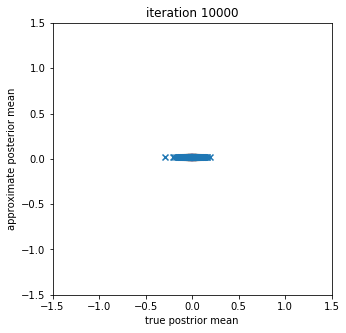

Epoch [10/10], Loss: 31.2723, Perplexity: 38139955680442.87



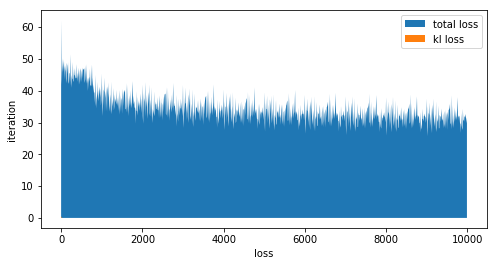

In [31]:
vae = VAE(hidden_size, num_layers, embedding_weights, latent_size, synthetic=True)

train(vae, inputs, targets, epochs, vocab_size, hidden_size, latent_size, plot=True, learning_rate=learning_rate,
      synthetic=True, step=step, tracked_inputs=tracked_inputs, tracked_targets=tracked_targets, plot_lim=1.5)

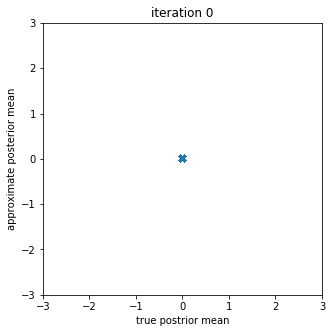

epoch 1 iteration 0 loss 62.167 CE 62.167 KL 0.000 weighted KL: 0.000 weight 0.002
epoch 1 iteration 100 loss 46.141 CE 46.131 KL 4.228 weighted KL: 0.010 weight 0.002
epoch 1 iteration 200 loss 45.409 CE 45.395 KL 4.358 weighted KL: 0.014 weight 0.003
epoch 1 iteration 300 loss 42.786 CE 42.780 KL 1.567 weighted KL: 0.006 weight 0.004
epoch 1 iteration 400 loss 45.664 CE 45.654 KL 1.892 weighted KL: 0.010 weight 0.005
epoch 1 iteration 500 loss 42.753 CE 42.748 KL 0.771 weighted KL: 0.005 weight 0.007
epoch 1 iteration 600 loss 48.203 CE 48.198 KL 0.657 weighted KL: 0.006 weight 0.009
epoch 1 iteration 700 loss 42.968 CE 42.950 KL 1.676 weighted KL: 0.018 weight 0.011
epoch 1 iteration 800 loss 43.520 CE 43.374 KL 10.349 weighted KL: 0.146 weight 0.014
epoch 1 iteration 900 loss 38.141 CE 38.066 KL 4.151 weighted KL: 0.075 weight 0.018


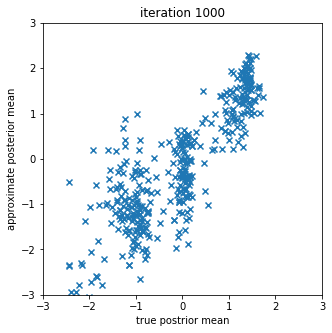

Epoch [1/10], Loss: 37.6173, Perplexity: 21726510032315272.00

epoch 2 iteration 1000 loss 43.729 CE 43.640 KL 3.843 weighted KL: 0.088 weight 0.023
epoch 2 iteration 1100 loss 35.666 CE 35.516 KL 5.126 weighted KL: 0.150 weight 0.029
epoch 2 iteration 1200 loss 35.839 CE 35.684 KL 4.161 weighted KL: 0.155 weight 0.037
epoch 2 iteration 1300 loss 31.119 CE 30.915 KL 4.300 weighted KL: 0.204 weight 0.047
epoch 2 iteration 1400 loss 36.911 CE 36.749 KL 2.694 weighted KL: 0.162 weight 0.060
epoch 2 iteration 1500 loss 32.389 CE 32.171 KL 2.871 weighted KL: 0.218 weight 0.076
epoch 2 iteration 1600 loss 40.579 CE 40.274 KL 3.190 weighted KL: 0.304 weight 0.095
epoch 2 iteration 1700 loss 33.164 CE 32.849 KL 2.639 weighted KL: 0.315 weight 0.119
epoch 2 iteration 1800 loss 34.245 CE 33.863 KL 2.580 weighted KL: 0.382 weight 0.148
epoch 2 iteration 1900 loss 34.352 CE 33.976 KL 2.064 weighted KL: 0.377 weight 0.182


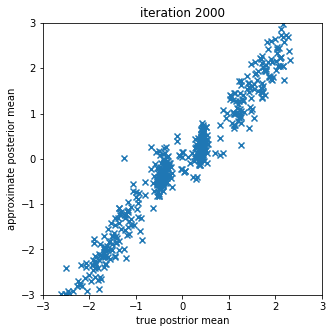

Epoch [2/10], Loss: 34.2055, Perplexity: 716556824297243.12

epoch 3 iteration 2000 loss 39.644 CE 39.108 KL 2.409 weighted KL: 0.537 weight 0.223
epoch 3 iteration 2100 loss 34.659 CE 34.153 KL 1.881 weighted KL: 0.506 weight 0.269
epoch 3 iteration 2200 loss 34.455 CE 33.777 KL 2.115 weighted KL: 0.679 weight 0.321
epoch 3 iteration 2300 loss 30.137 CE 29.314 KL 2.181 weighted KL: 0.823 weight 0.378
epoch 3 iteration 2400 loss 35.094 CE 34.337 KL 1.729 weighted KL: 0.757 weight 0.438
epoch 3 iteration 2500 loss 31.101 CE 30.197 KL 1.808 weighted KL: 0.904 weight 0.500
epoch 3 iteration 2600 loss 39.574 CE 38.481 KL 1.944 weighted KL: 1.093 weight 0.562
epoch 3 iteration 2700 loss 33.482 CE 32.342 KL 1.831 weighted KL: 1.140 weight 0.622
epoch 3 iteration 2800 loss 33.969 CE 32.831 KL 1.675 weighted KL: 1.138 weight 0.679
epoch 3 iteration 2900 loss 33.405 CE 32.275 KL 1.545 weighted KL: 1.130 weight 0.731


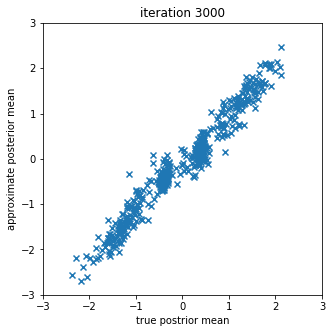

Epoch [3/10], Loss: 34.7067, Perplexity: 1182904160174472.75

epoch 4 iteration 3000 loss 39.401 CE 38.205 KL 1.538 weighted KL: 1.196 weight 0.777
epoch 4 iteration 3100 loss 34.265 CE 33.067 KL 1.465 weighted KL: 1.197 weight 0.818
epoch 4 iteration 3200 loss 33.812 CE 32.569 KL 1.459 weighted KL: 1.243 weight 0.852
epoch 4 iteration 3300 loss 30.684 CE 29.403 KL 1.454 weighted KL: 1.281 weight 0.881
epoch 4 iteration 3400 loss 35.614 CE 34.391 KL 1.352 weighted KL: 1.223 weight 0.905
epoch 4 iteration 3500 loss 31.374 CE 30.033 KL 1.451 weighted KL: 1.341 weight 0.924
epoch 4 iteration 3600 loss 39.468 CE 38.063 KL 1.495 weighted KL: 1.405 weight 0.940
epoch 4 iteration 3700 loss 32.325 CE 30.970 KL 1.422 weighted KL: 1.354 weight 0.953
epoch 4 iteration 3800 loss 34.011 CE 32.731 KL 1.330 weighted KL: 1.280 weight 0.963
epoch 4 iteration 3900 loss 32.690 CE 31.333 KL 1.398 weighted KL: 1.357 weight 0.971


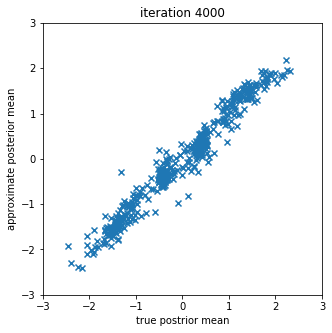

Epoch [4/10], Loss: 34.4178, Perplexity: 886052295114492.38

epoch 5 iteration 4000 loss 37.842 CE 36.504 KL 1.369 weighted KL: 1.338 weight 0.977
epoch 5 iteration 4100 loss 32.951 CE 31.761 KL 1.212 weighted KL: 1.191 weight 0.982
epoch 5 iteration 4200 loss 33.313 CE 31.975 KL 1.357 weighted KL: 1.338 weight 0.986
epoch 5 iteration 4300 loss 29.528 CE 27.979 KL 1.566 weighted KL: 1.549 weight 0.989
epoch 5 iteration 4400 loss 34.466 CE 33.181 KL 1.297 weighted KL: 1.286 weight 0.991
epoch 5 iteration 4500 loss 29.978 CE 28.738 KL 1.249 weighted KL: 1.240 weight 0.993
epoch 5 iteration 4600 loss 39.139 CE 37.751 KL 1.395 weighted KL: 1.388 weight 0.995
epoch 5 iteration 4700 loss 31.516 CE 30.166 KL 1.355 weighted KL: 1.350 weight 0.996
epoch 5 iteration 4800 loss 32.720 CE 31.499 KL 1.225 weighted KL: 1.221 weight 0.997
epoch 5 iteration 4900 loss 32.537 CE 31.291 KL 1.248 weighted KL: 1.245 weight 0.998


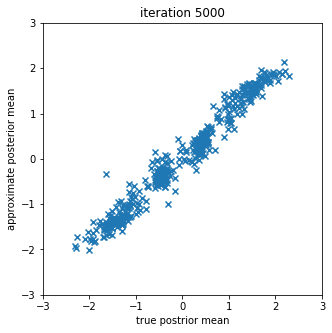

Epoch [5/10], Loss: 34.1948, Perplexity: 708914153620226.38

epoch 6 iteration 5000 loss 37.406 CE 36.171 KL 1.237 weighted KL: 1.235 weight 0.998
epoch 6 iteration 5100 loss 31.470 CE 30.135 KL 1.337 weighted KL: 1.335 weight 0.998
epoch 6 iteration 5200 loss 32.512 CE 31.260 KL 1.254 weighted KL: 1.252 weight 0.999
epoch 6 iteration 5300 loss 29.440 CE 27.895 KL 1.547 weighted KL: 1.545 weight 0.999
epoch 6 iteration 5400 loss 33.818 CE 32.575 KL 1.244 weighted KL: 1.243 weight 0.999
epoch 6 iteration 5500 loss 30.367 CE 29.118 KL 1.250 weighted KL: 1.249 weight 0.999
epoch 6 iteration 5600 loss 37.230 CE 35.900 KL 1.330 weighted KL: 1.330 weight 1.000
epoch 6 iteration 5700 loss 30.641 CE 29.513 KL 1.128 weighted KL: 1.128 weight 1.000
epoch 6 iteration 5800 loss 32.524 CE 31.314 KL 1.211 weighted KL: 1.210 weight 1.000
epoch 6 iteration 5900 loss 31.840 CE 30.564 KL 1.275 weighted KL: 1.275 weight 1.000


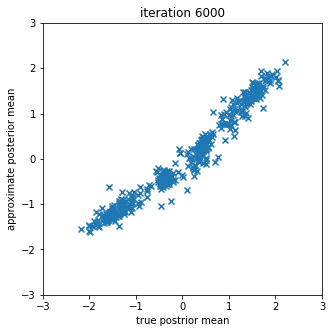

Epoch [6/10], Loss: 32.7353, Perplexity: 164719911135572.81

epoch 7 iteration 6000 loss 37.428 CE 36.254 KL 1.174 weighted KL: 1.174 weight 1.000
epoch 7 iteration 6100 loss 30.886 CE 29.739 KL 1.148 weighted KL: 1.147 weight 1.000
epoch 7 iteration 6200 loss 32.197 CE 30.947 KL 1.250 weighted KL: 1.250 weight 1.000
epoch 7 iteration 6300 loss 28.887 CE 27.469 KL 1.418 weighted KL: 1.418 weight 1.000
epoch 7 iteration 6400 loss 33.307 CE 32.155 KL 1.152 weighted KL: 1.151 weight 1.000
epoch 7 iteration 6500 loss 29.332 CE 28.056 KL 1.276 weighted KL: 1.276 weight 1.000
epoch 7 iteration 6600 loss 37.270 CE 36.064 KL 1.206 weighted KL: 1.206 weight 1.000
epoch 7 iteration 6700 loss 30.233 CE 29.046 KL 1.188 weighted KL: 1.188 weight 1.000
epoch 7 iteration 6800 loss 32.185 CE 30.892 KL 1.293 weighted KL: 1.293 weight 1.000
epoch 7 iteration 6900 loss 31.142 CE 29.759 KL 1.383 weighted KL: 1.383 weight 1.000


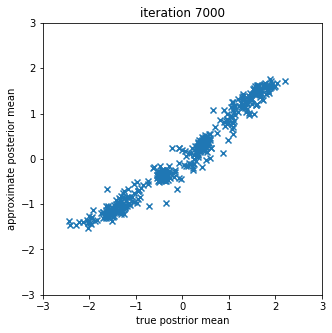

Epoch [7/10], Loss: 32.2664, Perplexity: 103062965876934.88

epoch 8 iteration 7000 loss 36.928 CE 35.721 KL 1.207 weighted KL: 1.207 weight 1.000
epoch 8 iteration 7100 loss 30.385 CE 29.274 KL 1.112 weighted KL: 1.112 weight 1.000
epoch 8 iteration 7200 loss 31.790 CE 30.591 KL 1.199 weighted KL: 1.199 weight 1.000
epoch 8 iteration 7300 loss 28.382 CE 26.915 KL 1.467 weighted KL: 1.467 weight 1.000
epoch 8 iteration 7400 loss 31.752 CE 30.547 KL 1.205 weighted KL: 1.205 weight 1.000
epoch 8 iteration 7500 loss 28.904 CE 27.648 KL 1.256 weighted KL: 1.256 weight 1.000
epoch 8 iteration 7600 loss 36.208 CE 34.951 KL 1.258 weighted KL: 1.258 weight 1.000
epoch 8 iteration 7700 loss 30.511 CE 29.226 KL 1.285 weighted KL: 1.285 weight 1.000
epoch 8 iteration 7800 loss 31.954 CE 30.660 KL 1.294 weighted KL: 1.294 weight 1.000
epoch 8 iteration 7900 loss 31.483 CE 30.178 KL 1.305 weighted KL: 1.305 weight 1.000


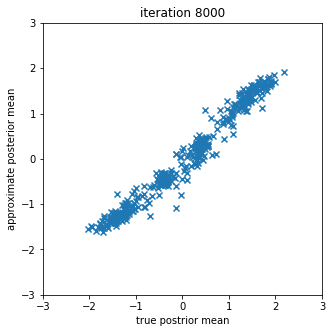

Epoch [8/10], Loss: 32.0138, Perplexity: 80063077364547.77

epoch 9 iteration 8000 loss 35.842 CE 34.613 KL 1.229 weighted KL: 1.229 weight 1.000
epoch 9 iteration 8100 loss 29.477 CE 28.162 KL 1.314 weighted KL: 1.314 weight 1.000
epoch 9 iteration 8200 loss 31.233 CE 29.891 KL 1.341 weighted KL: 1.341 weight 1.000
epoch 9 iteration 8300 loss 27.805 CE 26.435 KL 1.371 weighted KL: 1.371 weight 1.000
epoch 9 iteration 8400 loss 31.267 CE 30.038 KL 1.228 weighted KL: 1.228 weight 1.000
epoch 9 iteration 8500 loss 29.293 CE 28.011 KL 1.282 weighted KL: 1.282 weight 1.000
epoch 9 iteration 8600 loss 36.273 CE 35.073 KL 1.200 weighted KL: 1.200 weight 1.000
epoch 9 iteration 8700 loss 30.238 CE 28.976 KL 1.262 weighted KL: 1.262 weight 1.000
epoch 9 iteration 8800 loss 32.155 CE 30.917 KL 1.239 weighted KL: 1.239 weight 1.000
epoch 9 iteration 8900 loss 30.653 CE 29.351 KL 1.302 weighted KL: 1.302 weight 1.000


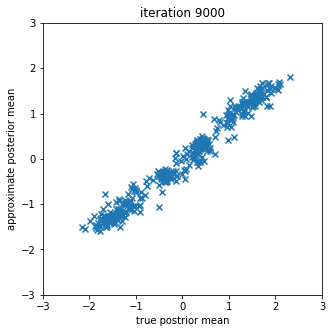

Epoch [9/10], Loss: 31.7943, Perplexity: 64281465160592.63

epoch 10 iteration 9000 loss 35.432 CE 34.209 KL 1.223 weighted KL: 1.223 weight 1.000
epoch 10 iteration 9100 loss 29.751 CE 28.456 KL 1.295 weighted KL: 1.295 weight 1.000
epoch 10 iteration 9200 loss 30.704 CE 29.403 KL 1.301 weighted KL: 1.301 weight 1.000
epoch 10 iteration 9300 loss 27.980 CE 26.567 KL 1.413 weighted KL: 1.413 weight 1.000
epoch 10 iteration 9400 loss 30.730 CE 29.447 KL 1.283 weighted KL: 1.283 weight 1.000
epoch 10 iteration 9500 loss 28.626 CE 27.339 KL 1.286 weighted KL: 1.286 weight 1.000
epoch 10 iteration 9600 loss 36.401 CE 35.101 KL 1.300 weighted KL: 1.300 weight 1.000
epoch 10 iteration 9700 loss 30.340 CE 29.129 KL 1.211 weighted KL: 1.211 weight 1.000
epoch 10 iteration 9800 loss 31.484 CE 30.261 KL 1.223 weighted KL: 1.223 weight 1.000
epoch 10 iteration 9900 loss 30.806 CE 29.556 KL 1.250 weighted KL: 1.250 weight 1.000


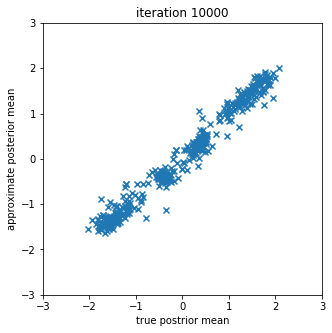

Epoch [10/10], Loss: 31.5059, Perplexity: 48178948975583.77



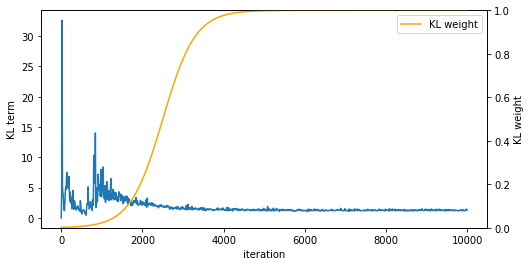

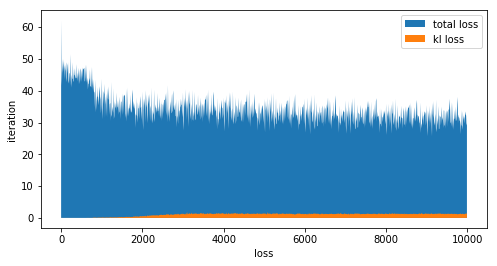

In [32]:
#with annealing
vocab_size = 1000
hidden_size = 50
embedding_size = 50
latent_size = 1
num_layers = 1
step = 0.25
learning_rate = 0.01
epochs = 10

vae = VAE(hidden_size, num_layers, embedding_weights, latent_size, synthetic=True)

annealing_args = {'type':'logistic', 'step':0, 'k':0.0025, 'first_step':2500}

train(vae, inputs, targets, epochs, vocab_size, hidden_size, latent_size, plot=True, learning_rate=learning_rate,
      synthetic=True, step=step, plot_lim=3, annealing_args=annealing_args, tracked_inputs=tracked_inputs, 
      tracked_targets=tracked_targets)

# TEXT DATA

### Create Word2Vec word embeddings

In [ ]:
embedding_size = 500
num_epochs_to_train = 10

word2vec_model = Word2Vec(train_data, min_count=1, size=embedding_size, window=5)
word2vec_model.train(train_data, epochs=num_epochs_to_train, total_examples=word2vec_model.corpus_count)

word2vec_model.wv.most_similar("stocks")
# word2vec_model.wv['credit']

vocabulary_size = len(word2vec_model.wv.vocab)
print("size of the vocabulary:", vocabulary_size)

### Define RNNLM

In [ ]:
class RNNLM(nn.Module):
    def __init__(self, vocabulary_size, embedding_size, hidden_size, num_layers, embedding_weights):
        super(RNNLM, self).__init__()
        self.embed = nn.Embedding.from_pretrained(embedding_weights)
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocabulary_size)
        self.embedding_size = embedding_size
        
    def forward(self, x, hidden, x_lens, train=True):
        batch_size, max_len, _ = x.shape
        embedding_dim = self.embedding_size

        x = self.embed(torch.tensor(x, dtype=torch.long)).view(batch_size, max_len, embedding_dim)
        if train:
            x_lens = torch.tensor(x_lens, dtype=torch.long)
            x = pack_padded_sequence(x, x_lens, batch_first=True)

        out, hidden = self.lstm(x.float(), hidden) 
        
        if train:
            out, output_lens = pad_packed_sequence(out, batch_first=True, total_length=max_sentence_length-1)

        out = out.reshape(out.size(0)*out.size(1), out.size(2))
        out = self.linear(out)
        
        return out, hidden

### Train and predict with RNNLM

In [ ]:
input_size = 100
output_size = 100
hidden_size = 50

batch_size = 20
use_first_k = 500
padding_index = vocabulary_size
train_batches, train_targets, train_sentence_lens = get_batches(train_data[:use_first_k], train_data_padded[:use_first_k], 
                                                                batch_size, padding_index, word2vec_model)

# make the word embeddings into a pythorch tensor
embedding_weights = word2vec_model.wv.vectors
embedding_weights = np.vstack((embedding_weights, np.zeros((1,embedding_size))))  # add zero vector for <pad>
embedding_weights = torch.tensor(embedding_weights)

learning_rate = 0.001
num_layers = 1
epochs = 10

model = RNNLM(vocabulary_size, embedding_size, hidden_size, num_layers, embedding_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    hidden = (torch.zeros(num_layers, batch_size, hidden_size), torch.zeros(num_layers, batch_size, hidden_size))
    for i in range(len(train_batches)):
        x = train_batches[i]
        x_lens = train_sentence_lens[i]
        y = torch.tensor(train_targets[i].reshape(-1), dtype=torch.long)   
        h, c = hidden
        h = h.detach()
        c = c.detach()
        hidden = (h, c)
    
        outputs, hidden = model(x, hidden, x_lens)
        
        mask = (y < padding_index)
        loss = nn.CrossEntropyLoss()(outputs[mask], y[mask])

        model.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

    if epoch % 1 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}, Perplexity: {:5.2f}'
               .format(epoch + 1, epochs, loss.item(), np.exp(loss.item())))

In [ ]:
# Predict
test_sentences = ["he could see"]
sentence, _ = tokenize_sentence(test_sentences[0], max_sentence_length)
sentence = sentence[:-1]
word_indexes = np.array([word2vec_model.wv.vocab[word].index for word in sentence]).reshape(1, len(sentence), 1)
print(word_indexes.shape)

hidden = (torch.zeros(1, 1, hidden_size), torch.zeros(1, 1, hidden_size))
h, c = hidden
h = h.detach()
c = c.detach()
hidden = (h, c)

outputs, hidden = model(word_indexes, hidden, x_lens, train=False)
softmax_outputs = F.softmax(outputs, dim=1).detach().numpy()
last_word = softmax_outputs[-1,:]
predicted_next_word_idx = np.random.choice(range(len(last_word)), p=last_word)
print("Argmax: ", word2vec_model.wv.index2word[np.argmax(last_word)])
print("Next word: ", word2vec_model.wv.index2word[predicted_next_word_idx])